# Imports

In [1]:
import os
import time
import random
import numpy as np

import tensorflow as tf
import tensorflow.contrib.layers as layers

import gym
from gym import spaces
from PIL import Image
from collections import deque, namedtuple
from atari_wrappers import wrap_deepmind

from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# Deep Q-Network and Experience Replay

In [2]:
from deep_q_learning import QNetwork, ReplayMemory

# Agent for playing Atari

In [3]:
class AtariAgent:
    
    def __init__(self, game_id, num_actions=None, model_name="baseline_agent"):
        """Class for training and evaluating DQN agent on Atari games
        
        Parameters
        ----------
        game_id: str
            game identifier in gym environment, e.g. "Pong"
        num_actions: int
            number of actions the agent can take
        model_name: str
            name of the model
        """
        
        ############################ Game environment ############################
        
        self.game_id = game_id + "NoFrameskip-v4"
        self.train_env = wrap_deepmind(gym.make(self.game_id))
        self.test_env = wrap_deepmind(gym.make(self.game_id), clip_rewards=False)
        
        if num_actions is None:
            self.num_actions = self.train_env.unwrapped.action_space.n
        else:
            self.num_actions = num_actions
            
        self.path = "./" + game_id + "/" + model_name
        if not os.path.exists(self.path):
            os.makedirs(self.path)
        
        ############################# Agent & Target #############################
        
        tf.reset_default_graph()
        self.agent_net = QNetwork(self.num_actions, num_atoms=51, 
                                  architecture="DistDQN", scope="agent")
        self.target_net = QNetwork(self.num_actions, num_atoms=51,
                                   architecture="DistDQN", scope="target")
        
        self.init = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
        
        all_vars = tf.trainable_variables()
        num_vars = len(all_vars) // 2
        self.agent_vars = all_vars[:num_vars]
        self.target_vars = all_vars[num_vars:]
        
    def set_parameters(self, 
                       replay_memory_size=50000,
                       replay_start_size=10000,
                       init_eps=1,
                       final_eps=0.1,
                       annealing_steps=1000000,
                       discount_factor=0.99,
                       max_episode_length=2000):
        
        self.rep_buffer = ReplayMemory(replay_memory_size)
        frame_count = 0
        while (frame_count < replay_start_size):
            s = self.train_env.reset()   
            for time_step in range(max_episode_length):
                a = np.random.randint(self.num_actions)
                s_, r, end, info = self.train_env.step(a)
                self.rep_buffer.push(s, a, r, s_, end)
                s = s_
                frame_count += 1
                if end:
                    if self.train_env.unwrapped.ale.lives() == 0: break
                    else: s = self.train_env.reset()
            self.train_env.unwrapped.reset()
                        
        self.eps = init_eps
        self.final_eps = final_eps
        self.eps_drop = (init_eps - final_eps) / annealing_steps
        self.gamma = discount_factor
        self.max_ep_length = max_episode_length
        
    def train(self,
              gpu_id=0,
              batch_size=32,
              agent_update_freq=4,
              target_update_freq=5000,
              tau=1,
              num_episodes=100000,
              model_save_freq=500,
              learning_curve_save_freq=500,
              performance_print_freq=500,
              model_test_freq=200000,
              test_episodes_num=20):
        
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        
        target_ops = self.update_target_graph(tau)
        test_freq_threshold = 1
        
        with tf.Session(config=config) as sess:
            sess.run(self.init)
            frame_count = 0
            
            train_rewards = []
            test_rewards = []
            frame_counts = []
            
            for i in range(num_episodes):
                s = self.train_env.reset()
                train_ep_reward = 0
                
                for time_step in range(self.max_ep_length):
                    
                    if np.random.rand(1) < self.eps:
                        a = np.random.randint(self.num_actions)
                    else:
                        a = self.agent_net.argmax_q(sess, [s])
                    s_, r, end, info = self.train_env.step(a)
                    self.rep_buffer.push(s, a, r, s_, end)
                    s = s_
                    frame_count += 1
                    train_ep_reward += r
                    
                    if self.eps > self.final_eps:
                        self.eps -= self.eps_drop
                        
                    if frame_count % agent_update_freq == 0:
                        
                        batch = self.rep_buffer.get_batch(batch_size)
                        
                        max_actions = self.agent_net.argmax_q(sess, batch.s_)
                        target_m = self.target_net.cat_proj(sess, batch.r, batch.s_, 
                                                            max_actions, batch.end)
                        self.agent_net.update(sess, batch.s, batch.a, target_m)
                        
                        if tau == 1:
                            if frame_count % target_update_freq == 0:
                                self.update_target_weights(sess, target_ops)
                        else: self.update_target_weights(sess, target_ops)
                            
                    if end: 
                        if self.train_env.unwrapped.ale.lives() == 0: break
                        else: s = self.train_env.reset()
                self.train_env.unwrapped.reset()
                           
                train_rewards.append(train_ep_reward)

                if i % model_save_freq == 0:
                    self.saver.save(sess, self.path+"/model-"+str(i)+".ckpt")
                    print("Model saved.")

                # periodically save the learning curve
                if i % learning_curve_save_freq == 0:
                    np.savez(self.path+"/learning_curve.npz", r=train_rewards)

                # periodically print model performance
                if i % performance_print_freq == 0:
                    avg_reward = np.mean(train_rewards[-performance_print_freq:])
                    print("Train info:", frame_count, avg_reward, self.eps)

                # periodicaly test greedy policy derived from the model
                if frame_count // test_freq_threshold > 0:
                    test_freq_threshold += model_test_freq
                    one_test_rewards = []

                    for j in range(test_episodes_num):
                        test_ep_reward = 0
                        s = self.test_env.reset()
                        for time_step in range(self.max_ep_length):
                            a = self.agent_net.argmax_q(sess, [s])
                            s, r, end, info = self.test_env.step(a)
                            test_ep_reward += r
                            if end: 
                                if self.test_env.unwrapped.ale.lives() == 0: break
                                else: s = self.test_env.reset()
                        self.test_env.unwrapped.reset()
                        one_test_rewards.append(test_ep_reward)

                    avg_reward = sum(one_test_rewards[-test_episodes_num:]) / test_episodes_num
                    frame_counts.append(frame_count)
                    test_rewards.append(one_test_rewards)

                    print("Test info:", frame_count, avg_reward)
                    np.savez(self.path+'/test_curve.npz', frames=frame_counts, r=test_rewards)            

    def update_target_graph(self, tau):
        op_holder = []
        for agnt, trgt in zip(self.agent_vars, self.target_vars):
            op = trgt.assign(agnt.value()*tau + (1 - tau)*trgt.value())
            op_holder.append(op)
        return op_holder

    def update_target_weights(self, sess, op_holder):
        for op in op_holder:
            sess.run(op)

# Train

In [5]:
aa = AtariAgent("Breakout", model_name="baseline_distributional")

[2017-10-19 12:53:31,962] Making new env: BreakoutNoFrameskip-v4
[2017-10-19 12:53:32,265] Making new env: BreakoutNoFrameskip-v4


In [ ]:
aa.set_parameters(max_episode_length=5000, replay_memory_size=100000, replay_start_size=50000)

In [ ]:
aa.train(gpu_id=0)

# Performace visualization

In [4]:
def plot_average(r, tau):
    ret = np.cumsum(r, dtype=np.float)
    ret[tau:] = ret[tau:] - ret[:-tau] 
    y = ret[tau - 1:] / tau
    return y

def score(arr, ind=0):
    if ind==0:
        return arr.min(axis=1)
    if ind==1:
        return arr.mean(axis=1)
    if ind==2:
        return arr.max(axis=1)
    if ind==3:
        arr = np.sort(arr)[:,-3:]
        return arr.mean(axis=1)
    
def plot_performance(path, eta=10, tau=1):
    
    r_train = np.load(path + "/learning_curve.npz")["r"]
    r_test = np.load(path + "/test_curve.npz")['r']
    frames = np.load(path + "/test_curve.npz")['frames']/1000000
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    x = plot_average(frames, tau)
    for i in range(3):
        y = plot_average(score(r_test, i), tau)
        ax[1].plot(x, y)
    ax[1].grid()
    
    y = plot_average(r_train, eta)
    x = np.linspace(x.min(), x.max(), y.size)
    
    ax[0].plot(x, y)
    ax[0].grid()
    print (r_test.max())

423.0


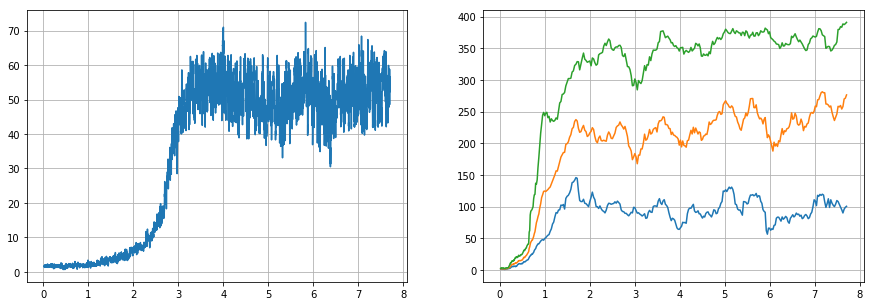

In [6]:
path = "Breakout/baseline_distributional/"
plot_performance(path, tau=10, eta=10)